本次作业以垃圾邮件分类任务为基础，要求提取文本特征并使用朴素贝叶斯算法进行垃圾邮件识别（调用已有工具包或自行实现）。

### 任务介绍
电子邮件是互联网的一项重要服务，在大家的学习、工作和生活中会广泛使用。但是大家的邮箱常常被各种各样的垃圾邮件填充了。有统计显示，每天互联网上产生的垃圾邮件有几百亿近千亿的量级。因此，对电子邮件服务提供商来说，垃圾邮件过滤是一项重要功能。而朴素贝叶斯算法在垃圾邮件识别任务上一直表现非常好，至今仍然有很多系统在使用朴素贝叶斯算法作为基本的垃圾邮件识别算法。

本次实验数据集来自[Trec06](https://plg.uwaterloo.ca/cgi-bin/cgiwrap/gvcormac/foo06)的中文垃圾邮件数据集，目录解压后包含三个文件夹，其中data目录下是所有的邮件（未分词），已分词好的邮件在data_cut目录下。邮件分为邮件头部分和正文部分，两部分之间一般有空行隔开。标签数据在label文件夹下，文件中每行是标签和对应的邮件路径。‘spam’表示垃圾邮件，‘ham’表示正常邮件。

本次实验

基本要求：
1. 提取正文部分的文本特征；
2. 划分训练集和测试集（可以借助工具包。一般笔记本就足够运行所有数据，认为实现困难或算力不够的同学可以采样一部分数据进行实验。）；
3. 使用朴素贝叶斯算法完成垃圾邮件的分类与预测，要求测试集准确率Accuracy、精准率Precision、召回率Recall均高于0.9（本次实验可以使用已有的一些工具包完成如sklearn）；
4. 对比特征数目（词表大小）对模型效果的影响；
5. 提交代码和实验报告。

扩展要求：
1. 邮件头信息有时也可以协助判断垃圾邮件，欢迎学有余力的同学们尝试；
2. 尝试自行实现朴素贝叶斯算法细节；
3. 尝试对比不同的概率计算方法。

### 导入工具包

In [32]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # 提取文本特征向量的类
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB # 三种朴素贝叶斯算法，差别在于估计p(x|y)的方式
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score,classification_report # 评价指标
from sklearn.model_selection import train_test_split, cross_validate # 划分数据集函数
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold  # 可选，用于指定交叉验证的折数
import matplotlib.pyplot as plt
import jieba as jb
from tqdm import tqdm

In [33]:
data_path = './trec06c-utf8/data/' # 数据集目录
data_cut_path = './trec06c-utf8/data_cut/' # 分词数据集目录
index_path = './trec06c-utf8/label/index' # 标签文件路径

# 一.基本要求

## 1.文件导入

### 1.1文件路径

In [34]:
df = pd.read_csv(index_path, header=None, sep='\s+') # header=None将第一行视作数据而不是标题，sep="\s+"是按空格进行划分
df.rename(columns={0:'label', 1:'addr'}, inplace=True)
# 文件的相对路径对于hw3.ipynb来说有变化，先将文件相对路径进行拼接
df['addr'] = r'./trec06c-utf8/data_cut/' + df['addr'].str.strip('./data')
df

,label,addr
0,spam,./trec06c-utf8/data_cut/000/000
1,ham,./trec06c-utf8/data_cut/000/001
2,spam,./trec06c-utf8/data_cut/000/002
3,spam,./trec06c-utf8/data_cut/000/003
4,spam,./trec06c-utf8/data_cut/000/004
...,...,...
64615,spam,./trec06c-utf8/data_cut/215/115
64616,spam,./trec06c-utf8/data_cut/215/116
64617,spam,./trec06c-utf8/data_cut/215/117
64618,spam,./trec06c-utf8/data_cut/215/118


### 1.2文件编码类型

In [35]:
file_path = './trec06c-utf8/data_cut/000/000'

In [36]:
import chardet
# 自动检测文件编码
with open(file_path, 'rb') as file:
    rawdata = file.read()
    result = chardet.detect(rawdata)
    encoding = result['encoding'] 
    print("文件编码为:",encoding)

文件编码为: utf-8


### 1.3提取邮件正文

In [37]:
import os

def extract_email(path):
    """读取一个邮件文件，返回邮件头和正文信息"""
    with open(path, 'r', encoding='utf-8') as f: # 读入文件
        file = f.read()
    head = file.split('\n\n',maxsplit=1)[0]
    text = file.split('\n\n',maxsplit=1)[1]
    return head, text

def find_all_files(directory):
    """查找目录下所有文件"""
    file_list = []
    if os.path.isfile(directory):
        # 根目录是文件则直接返回该目录
        file_list.append(directory)
        return file_list
    else:
        # os.walk递归遍历根目录下所有文件
        for root, dirs, files in os.walk(directory):
            for file in files:
                file_list.append(os.path.join(root, file))
        return file_list

def process_email(directory):
    """遍历指定目录，处理每个电子邮件文件"""
    email_head_list = []
    email_body_list = []
    file_list = find_all_files(directory)
    for filepath in file_list:
        if os.path.isfile(filepath):
            email_head, email_body = extract_email(filepath)
            email_head_list.append(email_head)
            email_body_list.append(email_body)
            # print(f"--- 邮件头提取自: {filepath[-7:]} ---\n{email_head}\n")
            # print(f"--- 正文提取自: {filepath[-7:]}---\n{email_body}\n")
    return email_head_list, email_body_list

# 没有选全部的数据集，太大了训练的好慢

In [38]:
# 指定根目录路径
root_directory = './trec06c-utf8/data_cut/000'
# root_directory = './trec06c-utf8/data_cut'
email_head, email_body = process_email(root_directory)

In [39]:
data = pd.DataFrame({'head':email_head, 'body':email_body, 'label':df['label'][:300]})
# data = pd.DataFrame({'head':email_head, 'body':email_body, 'label':df['label']})
data['label'] = data['label'].map(lambda x:1 if x=='spam' else 0)
data

,head,body,label
0,Received: from hp-5e1fe6310264 ([218.79.188.13...,[ 课 程 背 景 ]\n\n \n每 一位 管理 和 技术人员 都 清楚 地 ...,1
1,Received: from jdl.ac.cn ([159.226.42.8])\n\tb...,讲 的 是 孔子 后人 的 故事 。 一个 老 领导 回到 家乡 ， 跟 儿子 感情 不 和...,0
2,Received: from 163.con ([61.141.165.252])\n\tb...,尊敬 的 贵 公司 ( 财务 / 经理 ) 负责人 您好 ！\n我 是 深圳 金海 实业 有...,1
3,Received: from 12.com ([222.50.6.150])\n\tby s...,贵 公司 负责人 ( 经理 / 财务 ） 您好 ：\n深圳市 华龙 公司 受 多家 公司 委...,1
4,Received: from dghhkjk.com ([59.36.183.208])\n...,这是 一封 HTML 格式 信件 ！\n\n- - - - - - - - - - - - ...,1
...,...,...,...
295,Received: from gootom.com.cn ([61.149.33.170])...,顾问 通 – 求知者 与 专家 、 教授 交流 的 平台 。\n\n顾问 通 –...,1
296,Received: from sian.com ([218.18.67.12])\n\tby...,尊敬 的 公司 （ 工厂 ） 经理 负责人 你好 ：\n我 公司 是 一家 多年 为 外资企...,1
297,Received: from 163.com ([219.133.130.232])\n\t...,您好 ！\n我 深圳 宏易 实业 有限公司 。 公司 在 全国 各地 大城市 设有 分公司 ...,1
298,Received: from 163.com ([61.141.240.207])\n\tb...,您好 ！\n我 深圳 宏易 实业 有限公司 。 公司 在 全国 各地 大城市 设有 分公司 ...,1


## 2.划分数据集

In [40]:
X = data[['head', 'body']]
y = data['label']
RANDOM_SEED = 2024
# 先将数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# 然后将训练集进一步划分为训练集和验证集
train_indices, val_indices = train_test_split(np.arange(len(X_train)), test_size=0.1, random_state=RANDOM_SEED)

X_train.shape, y_train.shape, X_test.shape, y_test.shape, train_indices.shape, val_indices.shape

((240, 2), (240,), (60, 2), (60,), (216,), (24,))

In [41]:
X_train.head()

,head,body
147,Received: from 126.com ([219.136.126.168])\n\t...,\nFRAME : mainsoft\n\n\n\n\n
211,Received: from jdl.ac.cn ([159.226.42.8])\n\tb...,是不是 和 现在 的 他 闹矛盾 了 ？ cft ~ ~ ~ ~ ~ ~ ~ ~\n考研 的...
209,Received: from jdl.ac.cn ([159.226.42.8])\n\tb...,” 正当防卫 必须 具备 下列 条件 ：\n1 ． 起因 条件 。 正当防卫 的 起因 条件...
164,Received: from tom.com ([219.134.121.74])\n\tb...,贵 公司 负责人 ( 经理 / 财务 ） 您好 ：\n我 是 深圳市 华源 盛 实业 有限公...
32,Received: from 163.com ([222.50.13.9])\n\tby s...,贵 公司 负责人 ( 经理 / 财务 ） ： 您好 !\n\n我 是 深圳市 华雄 实业...


## 3.特征提取

### 3.1加载停用词

In [42]:
# 加载停用词
stopwords = [word.strip() for word in open('./stopwords.txt', encoding='utf-8')]
stopwords

['$',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '?',
 '_',
 '“',
 '”',
 '、',
 '。',
 '《',
 '》',
 '一',
 '一些',
 '一何',
 '一切',
 '一则',
 '一方面',
 '一旦',
 '一来',
 '一样',
 '一般',
 '一转眼',
 '万一',
 '上',
 '上下',
 '下',
 '不',
 '不仅',
 '不但',
 '不光',
 '不单',
 '不只',
 '不外乎',
 '不如',
 '不妨',
 '不尽',
 '不尽然',
 '不得',
 '不怕',
 '不惟',
 '不成',
 '不拘',
 '不料',
 '不是',
 '不比',
 '不然',
 '不特',
 '不独',
 '不管',
 '不至于',
 '不若',
 '不论',
 '不过',
 '不问',
 '与',
 '与其',
 '与其说',
 '与否',
 '与此同时',
 '且',
 '且不说',
 '且说',
 '两者',
 '个',
 '个别',
 '临',
 '为',
 '为了',
 '为什么',
 '为何',
 '为止',
 '为此',
 '为着',
 '乃',
 '乃至',
 '乃至于',
 '么',
 '之',
 '之一',
 '之所以',
 '之类',
 '乌乎',
 '乎',
 '乘',
 '也',
 '也好',
 '也罢',
 '了',
 '二来',
 '于',
 '于是',
 '于是乎',
 '云云',
 '云尔',
 '些',
 '亦',
 '人',
 '人们',
 '人家',
 '什么',
 '什么样',
 '今',
 '介于',
 '仍',
 '仍旧',
 '从',
 '从此',
 '从而',
 '他',
 '他人',
 '他们',
 '以',
 '以上',
 '以为',
 '以便',
 '以免',
 '以及',
 '以故',
 '以期',
 '以来',
 '以至',
 '以至于',
 '以致',
 '们',
 '任',
 '任何',
 '任凭',
 '似的',
 '但',
 '但凡',
 '但是',
 '何',
 '何以',
 '何况',
 '何处',
 '何时',
 '余外',
 '作为',
 '你',
 '你们'

In [43]:
def Create_Vec(v_type,max_df: float, min_df: int, stopwords: list):
    if v_type == 'CountVectorizer':    # 词频向量提取器
        vec = CountVectorizer(max_df = max_df, min_df = min_df, stop_words=stopwords)
    elif v_type == 'TfidfVectorizer':    # TF-IDF 向量提取器
        vec = TfidfVectorizer(max_df = max_df, min_df = min_df, stop_words=stopwords)
    else:   
        print('error: vectorizer type wrong!')
        return 0
    return vec
vectorizer = Create_Vec('CountVectorizer', 0.8, 5, stopwords)
vectorizer

CountVectorizer(max_df=0.8, min_df=5,
                stop_words=['$', '0', '1', '2', '3', '4', '5', '6', '7', '8',
                            '9', '?', '_', '“', '”', '、', '。', '《', '》', '一',
                            '一些', '一何', '一切', '一则', '一方面', '一旦', '一来', '一样',
                            '一般', '一转眼', ...])

### 3.2创建文本向量化器

(240, 914) (60, 914)


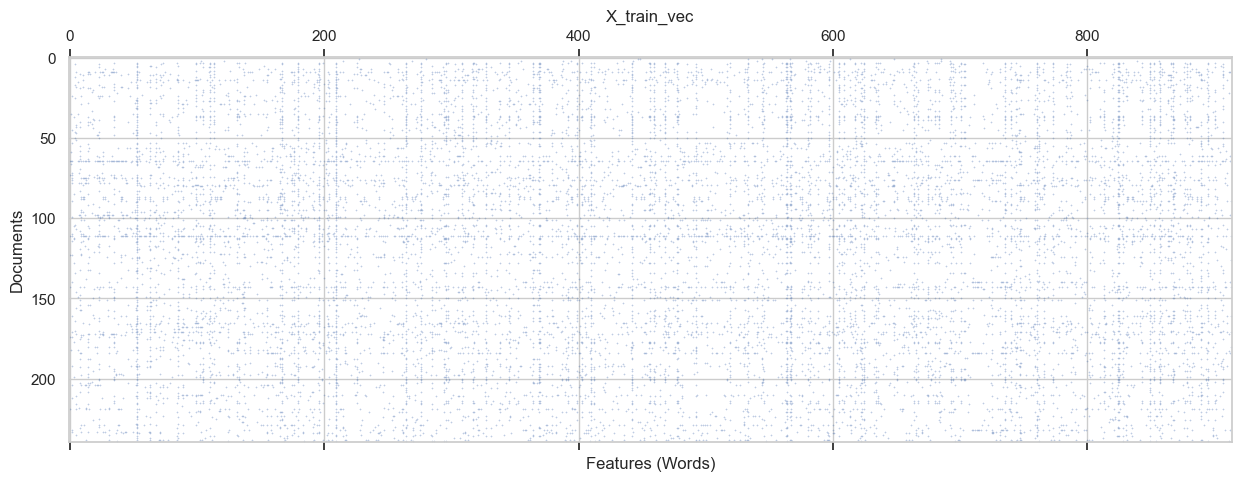

In [44]:
# 用训练集数据拟合向量化器vectorizer
X_train_vec = vectorizer.fit_transform(X_train['body'])
# print(X_train_vec,end="\n\n")
# 使用拟合好的向量器对测试集进行转化
X_test_vec = vectorizer.transform(X_test['body'])
print(X_train_vec.shape, X_test_vec.shape,end="\n\n") # 输出矩阵大小

plt.figure(figsize=(15, 5))
# plt.spy 函数用于绘制稀疏矩阵的非零元素分布，其中横坐标表示矩阵的列索引，纵坐标表示矩阵的行索引。
plt.spy(X_train_vec, markersize=0.1, aspect='auto')
plt.xlabel('Features (Words)')
plt.ylabel('Documents')
plt.title('X_train_vec')
plt.show()

## 4.模型训练与测试


### 4.1训练朴素贝叶斯模型（仅用邮件体）

In [45]:
# 使用Multinomial Naive Bayes对邮件正文进行训练
model_body = MultinomialNB()
model_body.fit(X_train_vec, y_train)

MultinomialNB()

### 4.2结果分析

In [46]:
# 获取类别为垃圾邮件和非垃圾邮件的特征对数概率
non_spam_class_prob = model_body.feature_log_prob_[0]
spam_class_prob = model_body.feature_log_prob_[1]

# 将对数概率转换为概率
prob_spam = np.exp(spam_class_prob)
prob_non_spam = np.exp(non_spam_class_prob)

# 获取词汇表
vocab = np.array(vectorizer.get_feature_names_out())
print('词汇表:', vocab,end='\n\n')

# 获取最大权重的索引（即对数概率最大的特征）
top_spam_words = np.argsort(spam_class_prob)[::-1][:10]
top_non_spam_words = np.argsort(non_spam_class_prob)[::-1][:10]
print('垃圾邮件最大权重索引:', top_spam_words)
print('非垃圾邮件最大权重索引:', top_non_spam_words, end='\n\n')

# 输出垃圾邮件和非垃圾邮件的主要影响词汇
print("Top words for spam:")
print(vocab[top_spam_words])
print(prob_spam[top_spam_words])

print("\nTop words for non-spam:")
print(vocab[top_non_spam_words])
print(prob_non_spam[top_non_spam_words])

词汇表: ['00' '007' '010' '013824374887' '013927477688' '020' '027' '05' '0755'
 '10' '100' '1000' '11' '12' '126' '13' '13510111626' '13686411777'
 '13826524660' '13926515323' '14' '15' '16' '163' '17' '18' '20' '200'
 '2000' '2002' '2003' '2005' '21' '22' '23' '24' '25' '26' '27' '28' '30'
 '300' '40' '50' '500' '600' '81577859' '900'
 '_________________________________________________________________' 'and'
 'asp' 'china' 'cn' 'com' 'email' 'exe' 'for' 'gg' 'good' 'home' 'hotmail'
 'htm' 'html' 'http' 'iframe' 'ip' 'is' 'it' 'mail' 'mm' 'msn' 'net'
 'qjh335' 'qq' 're' 'service' 'small' 'soft' 'szbssy' 'szxhongyi'
 'szxingh' 'tel' 'the' 'to' 'tom' 'www' 'yahoo' 'you' '一下' '一个' '一个月' '一份'
 '一句' '一天' '一定' '一家' '一年' '一张' '一条' '一次' '一款' '一点' '一直' '一种' '一起' '一部分'
 '万元' '三年' '上去' '上海' '上网' '上面' '下载' '不了' '不会' '不便' '不再' '不到' '不同' '不得不'
 '不想' '不能' '不要' '不错' '专业' '专家' '专用' '专门' '世界' '世界各地' '世纪' '业务' '业绩' '东莞'
 '东讯' '两个' '个人' '中国' '中心' '中文' '丰富' '主管' '主要' '主题' '之内' '之前' '之后' '也许'
 '书籍' '了解' '事业' 

### 4.3可视化

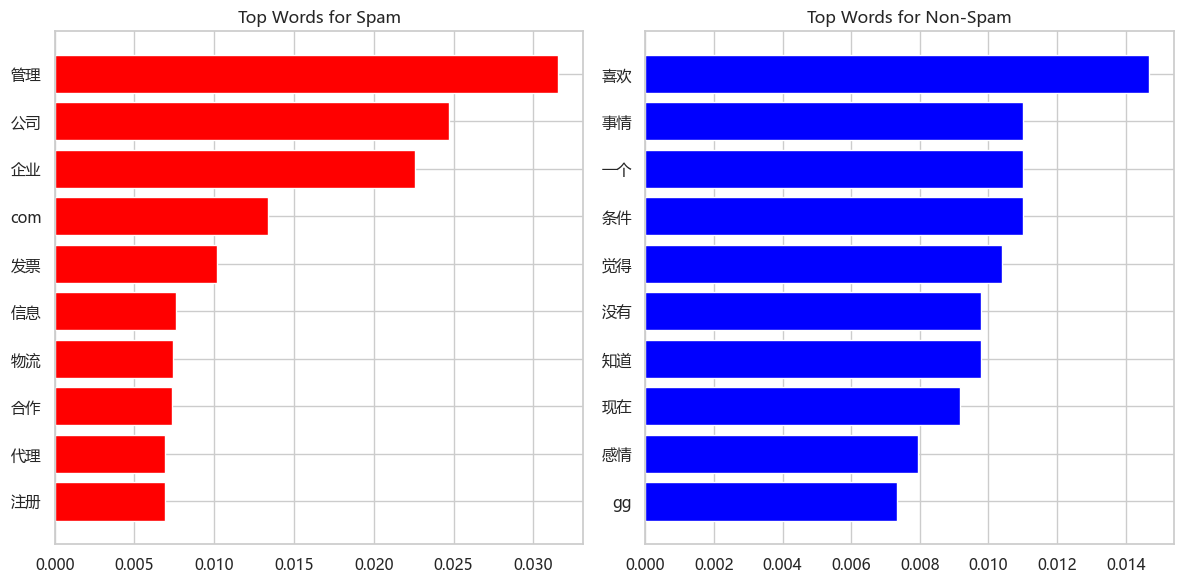

In [47]:
#v 获取 邮件体 中垃圾邮件与非垃圾邮件中权重最高的十个词汇，并利用柱状图显示
plt.figure(figsize=(12, 6))
plt.rcParams['font.family'] = 'Microsoft YaHei'

plt.subplot(1, 2, 1)
plt.barh(range(10), prob_spam[top_spam_words], color='red')
plt.yticks(range(10), vocab[top_spam_words])
plt.gca().invert_yaxis()
plt.title('Top Words for Spam')

plt.subplot(1, 2, 2)
plt.barh(range(10), prob_non_spam[top_non_spam_words], color='blue')
plt.yticks(range(10), vocab[top_non_spam_words])
plt.gca().invert_yaxis()
plt.title('Top Words for Non-Spam')

plt.tight_layout()
plt.show()

### 4.4测试集测试

In [48]:
# 根据邮件体预测 测试集
y_pred = model_body.predict(X_test_vec)

# 性能评估
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.5f}%",end='\n\n')

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=1))

Accuracy: 98.33333%

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.98      0.99        52

    accuracy                           0.98        60
   macro avg       0.94      0.99      0.97        60
weighted avg       0.99      0.98      0.98        60


预测邮件为垃圾邮件的准确率为98.33333%
预测为垃圾邮件的查准率P：100%
预测为垃圾邮件的查全率R：98%
预测为正常邮件的查准率P：89%
预测为正常邮件的查全率R：100%

## 5.模型调优

### 5.1查看不同种类向量提取器及其参数和不同种类朴素贝叶斯分类器对模型的影响

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
from sklearn.metrics import accuracy_score

# 定义多个特征提取器和分类器
feature_extractors = [
    ('count_vect', CountVectorizer()),
    ('tfidf_vect', TfidfVectorizer())
]

classifiers = [
    ('MultinomialNB', MultinomialNB()),
    ('BernoulliNB', BernoulliNB()),
    ('ComplementNB', ComplementNB())
]

# 存储每次搜索的结果
search_results = []

# 对每个组合定义参数搜索空间
param_grids = []
for extractor_name, _ in feature_extractors:
    for classifier_name, _ in classifiers:
        parameters = {
            f'{extractor_name}__max_df': (0.25, 0.5, 0.75, 1.0),
            f'{extractor_name}__min_df': (1, 2, 5, 10),
            f'{extractor_name}__ngram_range': ((1, 1), (1, 2)),
            f'{classifier_name}__alpha': (0.1, 0.5, 1.0),
        }
        param_grids.append((extractor_name, classifier_name, parameters))

# 创建多个 Pipeline 并进行组合，然后对每个 Pipeline 执行 GridSearch
for extractor_name, extractor in feature_extractors:
    for classifier_name, classifier in classifiers:
        pipeline = Pipeline([
            (extractor_name, extractor),
            (classifier_name, classifier)
        ])
        
        # 选择对应的参数字典
        parameters = next(param for ext_name, cls_name, param in param_grids if ext_name == extractor_name and cls_name == classifier_name)

        # 创建 GridSearchCV 对象
        grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=3)
        
        # 在训练数据上搜索最佳参数
        grid_search.fit(X_train['body'], y_train)
        
        # 存储每次搜索的最佳得分和参数
        search_results.append((grid_search.best_score_, extractor_name, classifier_name, grid_search.best_params_))

# 找出最佳得分的搜索
best_score, best_extractor, best_classifier, best_params = max(search_results, key=lambda x: x[0])

# 输出最佳得分的搜索结果
print("Best overall score: %0.3f" % best_score)
print("Best pipeline:", best_extractor, "with", best_classifier)
print("Best parameters set:")
for param_name, param_value in best_params.items():
    print("\t%s: %r" % (param_name, param_value))

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best overall score: 0.979
Best pipeline: count_vect with MultinomialNB
Best parameters set:
	MultinomialNB__alpha: 0.1
	count_vect__max_df: 0.25
	count_vect__min_df: 1
	count_vect__ngram_range: (1, 2)


### Best pipeline: count_vect with MultinomialNB

### Best parameters:alpha: 0.1; max_df: 0.25; min_df: 1; ngram_range: (1, 2);

In [50]:
# 使用最佳参数组合重新构建最优模型  
best_extractor_obj = [ext for ext_name, ext in feature_extractors if ext_name == best_extractor][0]
best_classifier_obj = [cls for cls_name, cls in classifiers if cls_name == best_classifier][0]

best_pipeline = Pipeline([
    (best_extractor, best_extractor_obj),
    (best_classifier, best_classifier_obj)
])

# 使用最佳参数设置重新训练模型
best_pipeline.set_params(**best_params).fit(X_train['body'], y_train)

# 对测试集进行预测
y_pred = best_pipeline.predict(X_test['body'])

# 性能评估
test_acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.5f}%",end='\n\n')

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=1))

Accuracy: 98.33333%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        52

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60


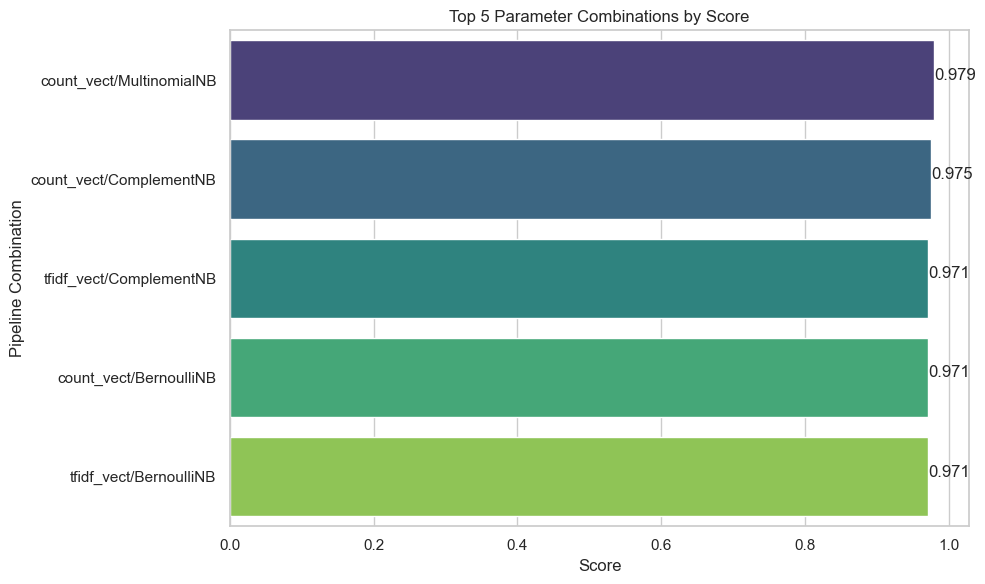

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# 将搜索结果按得分排序
sorted_search_results = sorted(search_results, key=lambda x: x[0], reverse=True)
# 取得分最高的前5个参数组合
top_5_results = sorted_search_results[:5]
# 可视化
sns.set(style="whitegrid")

# 准备可视化的数据
scores = [result[0] for result in top_5_results]
combinations = [f"{result[1]}/{result[2]}" for result in top_5_results]

# 创建条形图
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=scores, y=combinations, palette="viridis")

plt.xlabel('Score')
plt.ylabel('Pipeline Combination')
plt.title('Top 5 Parameter Combinations by Score')

# 在条形图上添加注解
for index, value in enumerate(scores):
    plt.text(value, index, f"{value:.3f}")

plt.tight_layout()
plt.show()

# 使用CountVectorizer向量化方法和MultinomialNB朴素贝叶斯模型效果最好

## 5.2查看词表大小对模型的影响

100%|██████████| 7/7 [00:00<00:00, 10.11it/s]


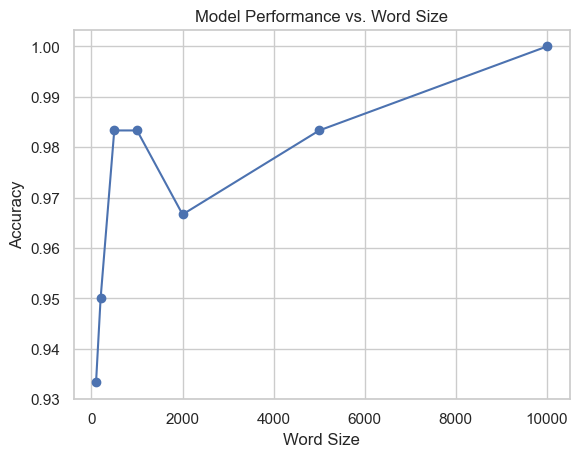

In [52]:
# 定义不同的词表大小
word_sizes = [100, 200, 500, 1000, 2000, 5000, 10000]

# 存储结果的列表
accuracies = []

# 循环实验
for word_size in tqdm(word_sizes):
    # 配置文本向量化器
    vectorizer = CountVectorizer(max_features=word_size)
    
    # 数据处理
    xbody_train = vectorizer.fit_transform(X_train['body']) 
    xbody_test = vectorizer.transform(X_test['body'])
    # 模型训练
    model_heads = MultinomialNB()
    model_heads.fit(xbody_train, y_train)

    # 模型预测
    ybody_pred = model_heads.predict(xbody_test)
    
    # 评估性能
    accuracy = accuracy_score(y_test, ybody_pred)
    
    # 存储结果
    accuracies.append(accuracy)

# 绘制折线图
plt.plot(word_sizes, accuracies, marker='o')
plt.title('Model Performance vs. Word Size')
plt.xlabel('Word Size')
plt.ylabel('Accuracy')
plt.show()

## 6.总结

这次数据集量特别大，作为一名新手，在以下几个地方被卡住了：

* 导入数据集时，不知道如何将不同文件夹的文件都用pandas导入进同一个dataframe
* 不明白实验流程，每一步要做什么不清楚，在训练贝叶斯模型前开始都不知道要向量化，模型训练完不知道要做什么
* 模型调优时对于调参流程不够熟练，数据处理时的参数和模型训练时的参数不知道怎么同时处理。
# 最后一边查资料一边处理，总算是做完了基础部分，学到了很多

# 二.扩展要求

## 1.邮件头

(240, 1431) (60, 1431)


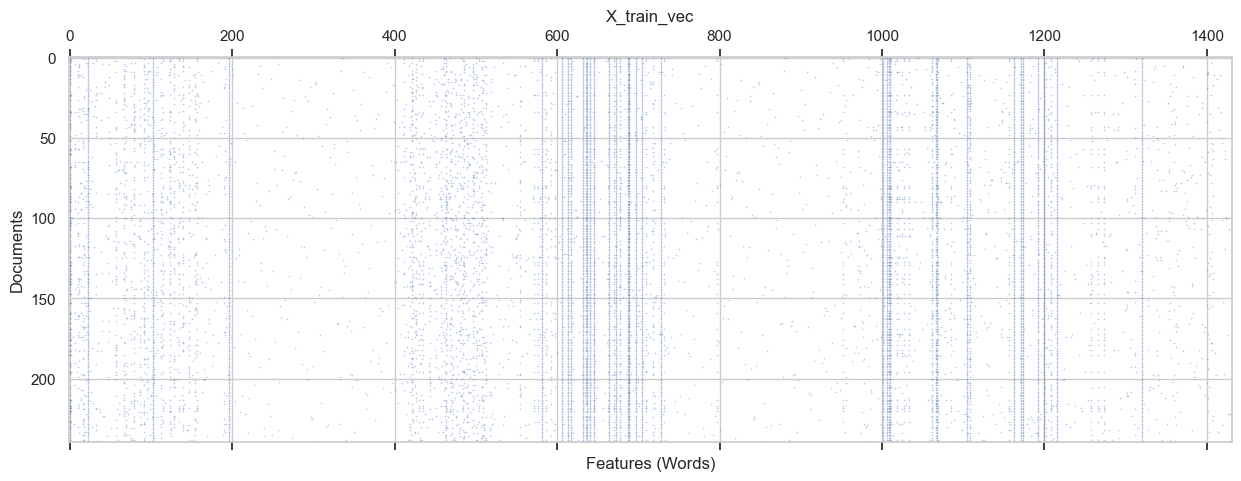

In [53]:
# 用训练集数据拟合向量化器vectorizer
X_train_vec = vectorizer.fit_transform(X_train['head'])
# print(X_train_vec,end="\n\n")
# 使用拟合好的向量器对测试集进行转化
X_test_vec = vectorizer.transform(X_test['head'])
print(X_train_vec.shape, X_test_vec.shape,end="\n\n") # 输出矩阵大小

plt.figure(figsize=(15, 5))
# plt.spy 函数用于绘制稀疏矩阵的非零元素分布，其中横坐标表示矩阵的列索引，纵坐标表示矩阵的行索引。
plt.spy(X_train_vec, markersize=0.1, aspect='auto')
plt.xlabel('Features (Words)')
plt.ylabel('Documents')
plt.title('X_train_vec')
plt.show()

In [54]:
# 使用Multinomial Naive Bayes对邮件正文进行训练
model_head = MultinomialNB()
model_head.fit(X_train_vec, y_train)

MultinomialNB()

In [55]:
# 获取类别为垃圾邮件和非垃圾邮件的特征对数概率
non_spam_class_prob = model_head.feature_log_prob_[0]
spam_class_prob = model_head.feature_log_prob_[1]

# 将对数概率转换为概率
prob_spam = np.exp(spam_class_prob)
prob_non_spam = np.exp(non_spam_class_prob)

# 获取词汇表
vocab = np.array(vectorizer.get_feature_names_out())
print('词汇表:', vocab,end='\n\n')

# 获取最大权重的索引（即对数概率最大的特征）
top_spam_words = np.argsort(spam_class_prob)[::-1][:10]
top_non_spam_words = np.argsort(non_spam_class_prob)[::-1][:10]
print('垃圾邮件最大权重索引:', top_spam_words)
print('非垃圾邮件最大权重索引:', top_non_spam_words, end='\n\n')

# 输出垃圾邮件和非垃圾邮件的主要影响词汇
print("Top words for spam:")
print(vocab[top_spam_words])
print(prob_spam[top_spam_words])

print("\nTop words for non-spam:")
print(vocab[top_non_spam_words])
print(prob_non_spam[top_non_spam_words])

词汇表: ['00' '0000' '000b01c59ee0' ... '您的ip' '网络电视' '请检查']

垃圾邮件最大权重索引: [ 632  664  613  697  635  102  689  196  728 1173]
非垃圾邮件最大权重索引: [ 632  102  689  196 1173  581 1104  664  606  613]

Top words for spam:
['cn' 'edu' 'ccert' 'gb2312' 'com' '14' 'from' '2005' 'id' 'sun']
[0.05050971 0.0428769  0.04282567 0.02663798 0.0264843  0.02433277
 0.02279596 0.02213001 0.02202756 0.02197633]

Top words for non-spam:
['cn' '14' 'from' '2005' 'sun' 'aug' 'received' 'edu' 'by' 'ccert']
[0.02784665 0.02536716 0.02231547 0.02231547 0.02231547 0.02231547
 0.01678428 0.01678428 0.01678428 0.01678428]


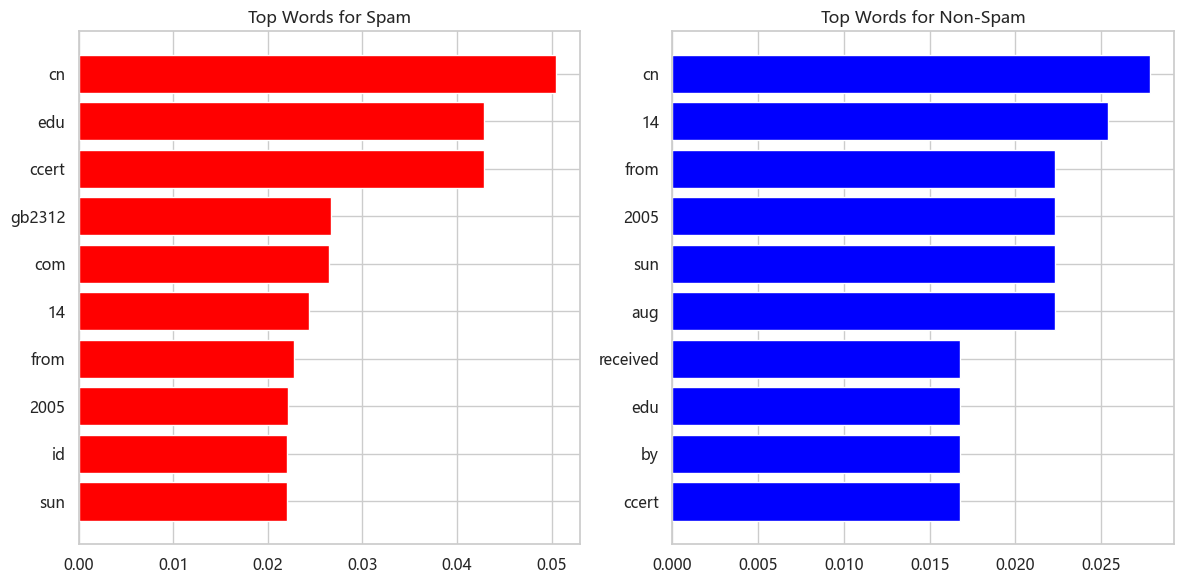

In [56]:
# 获取 邮件头 中垃圾邮件与非垃圾邮件中权重最高的十个词汇，并利用柱状图显示
plt.figure(figsize=(12, 6))
plt.rcParams['font.family'] = 'Microsoft YaHei'

plt.subplot(1, 2, 1)
plt.barh(range(10), prob_spam[top_spam_words], color='red')
plt.yticks(range(10), vocab[top_spam_words])
plt.gca().invert_yaxis()
plt.title('Top Words for Spam')

plt.subplot(1, 2, 2)
plt.barh(range(10), prob_non_spam[top_non_spam_words], color='blue')
plt.yticks(range(10), vocab[top_non_spam_words])
plt.gca().invert_yaxis()
plt.title('Top Words for Non-Spam')

plt.tight_layout()
plt.show()

In [57]:
# 根据邮件头预测 测试集
y_pred = model_head.predict(X_test_vec)

# 性能评估
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.5f}%",end='\n\n')

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=1))

Accuracy: 100.00000%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        52

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60


    预测邮件为垃圾邮件的准确率为100%
    预测为垃圾邮件的查准率P：100%
    预测为垃圾邮件的查全率R：100%
    预测为正常邮件的查准率P：100%
    预测为正常邮件的查全率R：100%

In [58]:
# 定义多个特征提取器和分类器
feature_extractors = [
    ('count_vect', CountVectorizer()),
    ('tfidf_vect', TfidfVectorizer())
]

classifiers = [
    ('MultinomialNB', MultinomialNB()),
    ('BernoulliNB', BernoulliNB()),
    ('ComplementNB', ComplementNB())
]

# 存储每次搜索的结果
search_results = []

# 对每个组合定义参数搜索空间
param_grids = []
for extractor_name, _ in feature_extractors:
    for classifier_name, _ in classifiers:
        parameters = {
            f'{extractor_name}__max_df': (0.25, 0.5, 0.75, 1.0),
            f'{extractor_name}__min_df': (1, 2, 5, 10),
            f'{extractor_name}__ngram_range': ((1, 1), (1, 2)),
            f'{classifier_name}__alpha': (0.1, 0.5, 1.0),
        }
        param_grids.append((extractor_name, classifier_name, parameters))

# 创建多个 Pipeline 并进行组合，然后对每个 Pipeline 执行 GridSearch
for extractor_name, extractor in tqdm(feature_extractors):
    for classifier_name, classifier in classifiers:
        pipeline = Pipeline([
            (extractor_name, extractor),
            (classifier_name, classifier)
        ])
        
        # 选择对应的参数字典
        parameters = next(param for ext_name, cls_name, param in param_grids if ext_name == extractor_name and cls_name == classifier_name)

        # 创建 GridSearchCV 对象
        grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=3)
        
        # 在训练数据上搜索最佳参数
        grid_search.fit(X_train['head'], y_train)
        
        # 存储每次搜索的最佳得分和参数
        search_results.append((grid_search.best_score_, extractor_name, classifier_name, grid_search.best_params_))

# 找出最佳得分的搜索
best_score, best_extractor, best_classifier, best_params = max(search_results, key=lambda x: x[0])

# 输出最佳得分的搜索结果
print("Best overall score: %0.3f" % best_score)
print("Best pipeline:", best_extractor, "with", best_classifier)
print("Best parameters set:")
for param_name, param_value in best_params.items():
    print("\t%s: %r" % (param_name, param_value))

  0%|          | 0/2 [00:00<?, ?it/s]

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits


 50%|█████     | 1/2 [00:12<00:12, 12.88s/it]

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits


100%|██████████| 2/2 [00:25<00:00, 12.74s/it]

Best overall score: 1.000
Best pipeline: count_vect with MultinomialNB
Best parameters set:
	MultinomialNB__alpha: 0.1
	count_vect__max_df: 0.25
	count_vect__min_df: 1
	count_vect__ngram_range: (1, 1)


In [59]:
# 使用最佳参数组合重新构建最优模型  
best_extractor_obj = [ext for ext_name, ext in feature_extractors if ext_name == best_extractor][0]
best_classifier_obj = [cls for cls_name, cls in classifiers if cls_name == best_classifier][0]

best_pipeline = Pipeline([
    (best_extractor, best_extractor_obj),
    (best_classifier, best_classifier_obj)
])

# 使用最佳参数设置重新训练模型
best_pipeline.set_params(**best_params).fit(X_train['head'], y_train)

# 对测试集进行预测
y_pred = best_pipeline.predict(X_test['head'])

# 性能评估
test_acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.5f}%",end='\n\n')

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=1))

Accuracy: 100.00000%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        52

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60


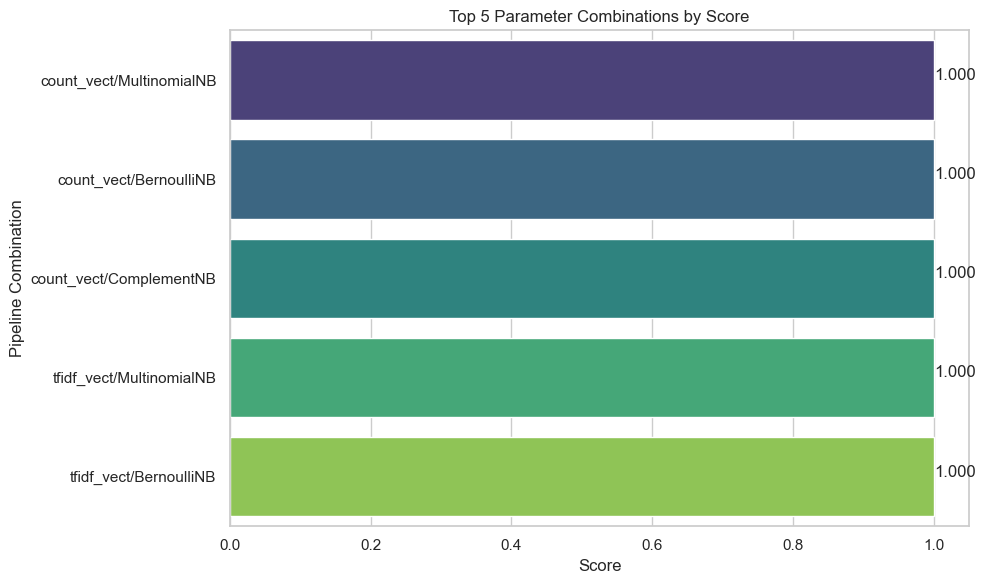

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# 将搜索结果按得分排序
sorted_search_results = sorted(search_results, key=lambda x: x[0], reverse=True)
# 取得分最高的前5个参数组合
top_5_results = sorted_search_results[:5]
# 可视化
sns.set(style="whitegrid")

# 准备可视化的数据
scores = [result[0] for result in top_5_results]
combinations = [f"{result[1]}/{result[2]}" for result in top_5_results]

# 创建条形图
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=scores, y=combinations, palette="viridis")

plt.xlabel('Score')
plt.ylabel('Pipeline Combination')
plt.title('Top 5 Parameter Combinations by Score')

# 在条形图上添加注解
for index, value in enumerate(scores):
    plt.text(value, index, f"{value:.3f}")

plt.tight_layout()
plt.show()

100%|██████████| 7/7 [00:00<00:00, 37.53it/s]


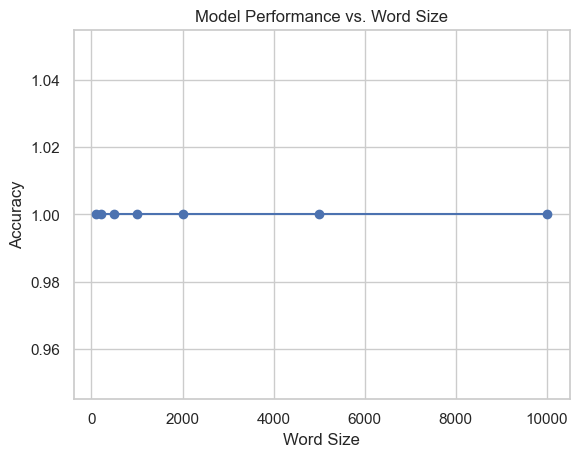

In [61]:
# 定义不同的词表大小
word_sizes = [100, 200, 500, 1000, 2000, 5000, 10000]

# 存储结果的列表
accuracies = []

# 循环实验
for word_size in tqdm(word_sizes):
    # 配置文本向量化器
    vectorizer = CountVectorizer(max_features=word_size)
    
    # 数据处理
    xbody_train = vectorizer.fit_transform(X_train['head']) 
    xbody_test = vectorizer.transform(X_test['head'])
    # 模型训练
    model_heads = MultinomialNB()
    model_heads.fit(xbody_train, y_train)

    # 模型预测
    ybody_pred = model_heads.predict(xbody_test)
    
    # 评估性能
    accuracy = accuracy_score(y_test, ybody_pred)
    
    # 存储结果
    accuracies.append(accuracy)

# 绘制折线图
plt.plot(word_sizes, accuracies, marker='o')
plt.title('Model Performance vs. Word Size')
plt.xlabel('Word Size')
plt.ylabel('Accuracy')
plt.show()


# 使用邮件头信息单独建模，比用邮件体的表现好